In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
NEW_TABLES_DIRECTORY = "../../Data/giant_tables_filled_only"

In [3]:
def get_patient_hup_ids(directory):
    # List all files in the directory
    files = os.listdir(directory)

    # Filter out files based on the given pattern and extract patient_hup_id as integers
    patient_hup_ids = [
        int(f.split("_")[1].split(".")[0])
        for f in files
        if f.startswith("HUP_") and f.endswith(".npy")
    ]

    return patient_hup_ids


directory = "../../Data/synchrony/all/broadband_fill_intermediate/"
completed_hup_ids = get_patient_hup_ids(directory)
completed_hup_ids.sort()
print(completed_hup_ids)
len(completed_hup_ids)

[139, 143, 146, 155, 160, 161, 162, 165, 171]


9

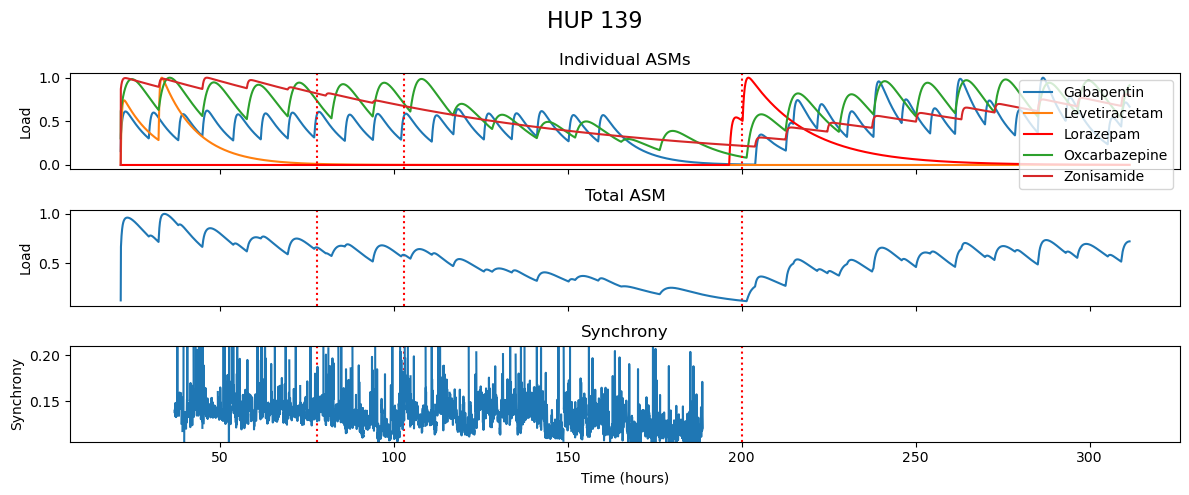

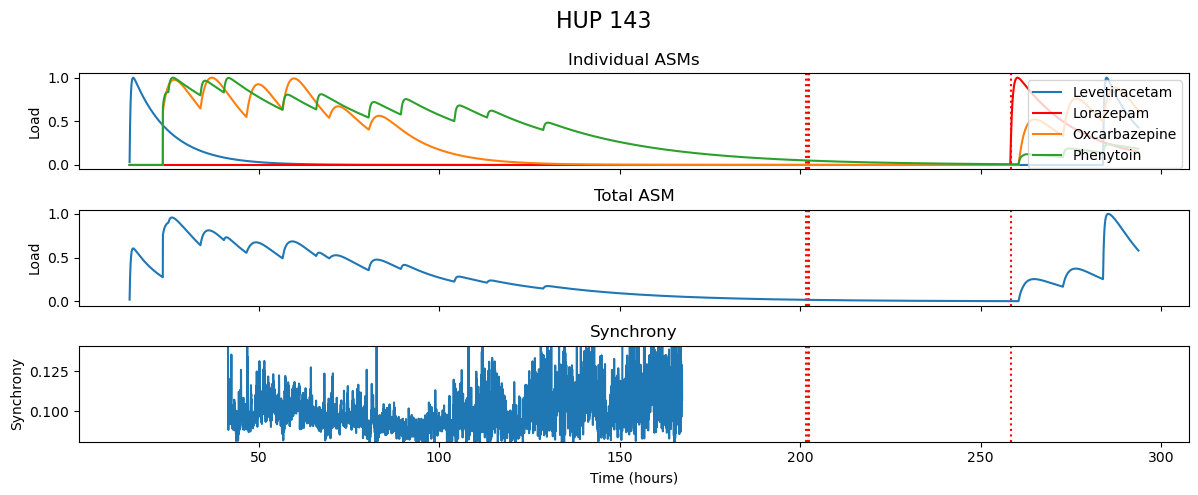

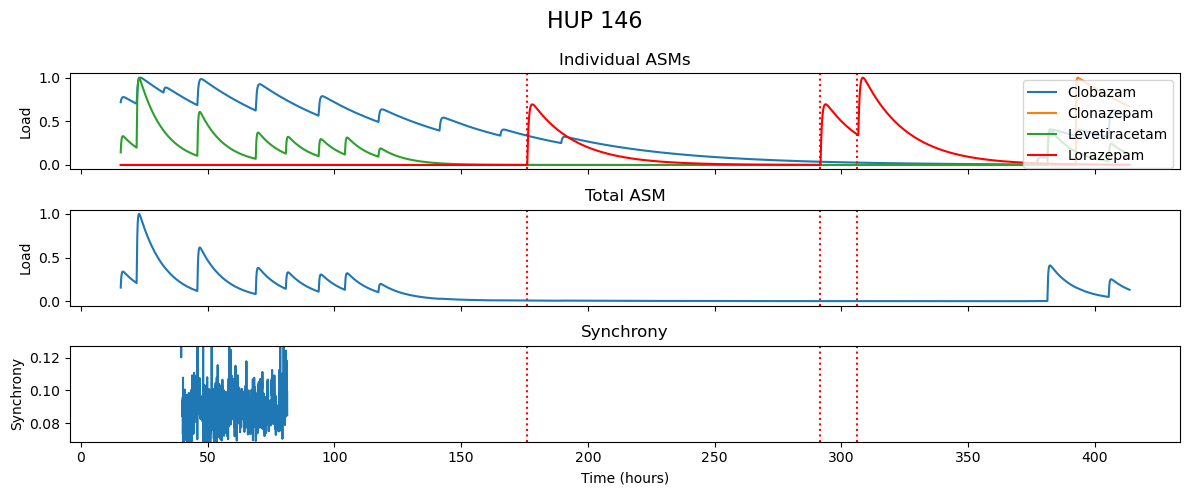

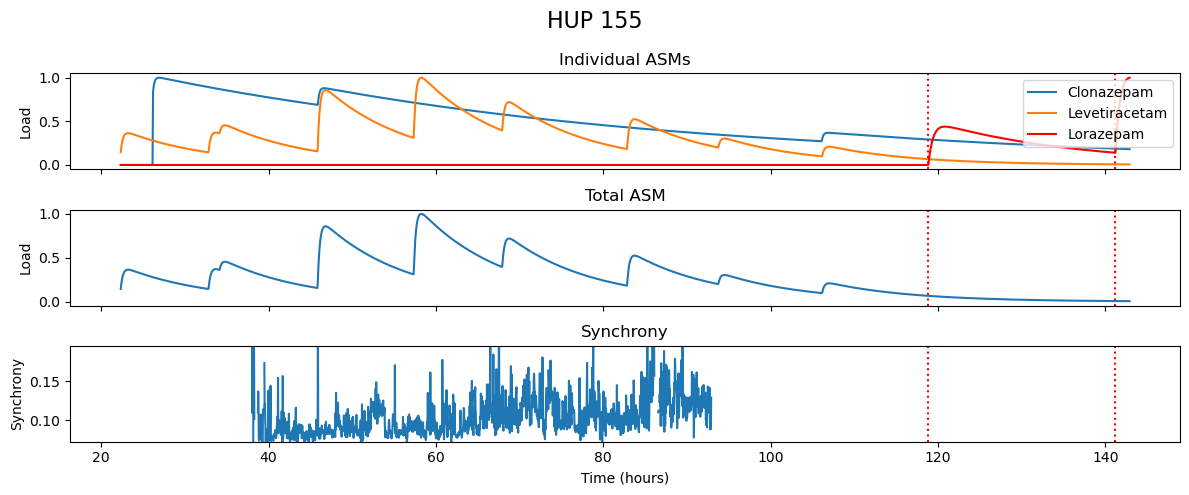

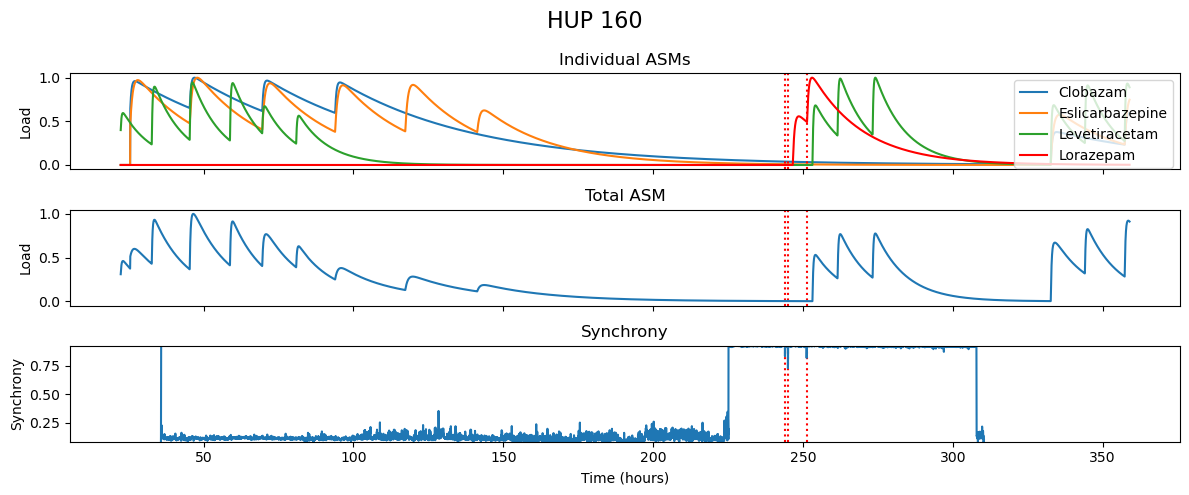

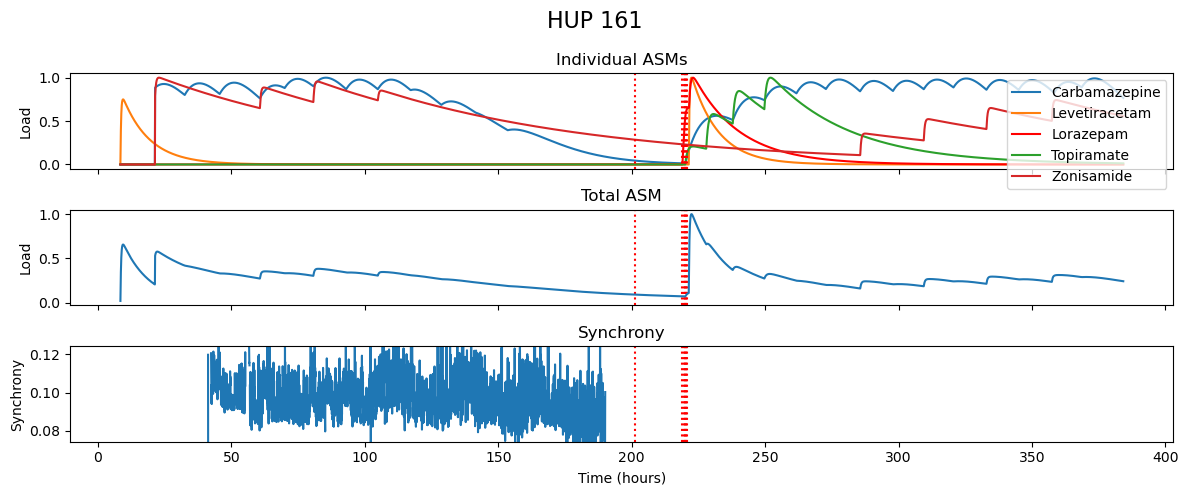

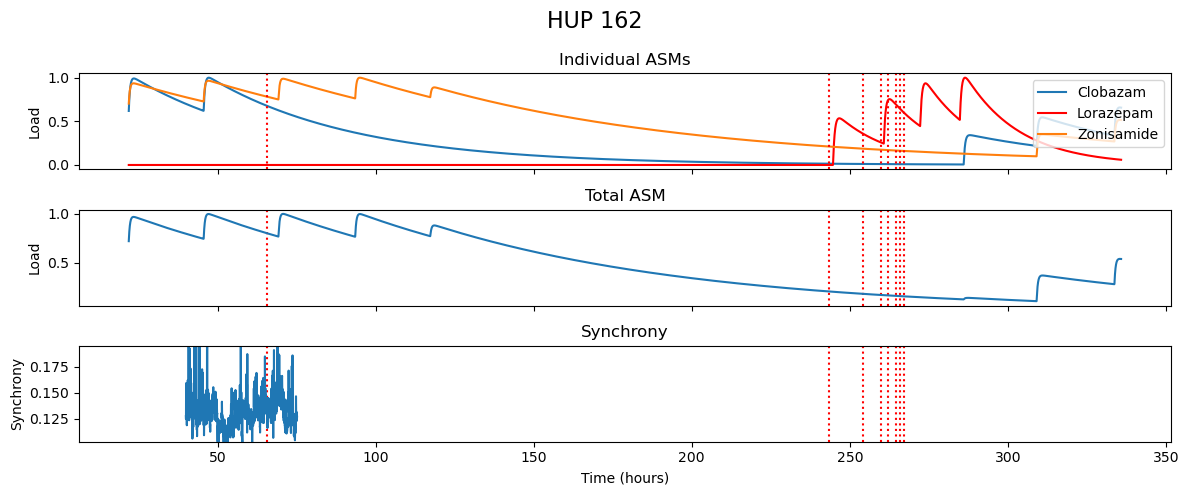

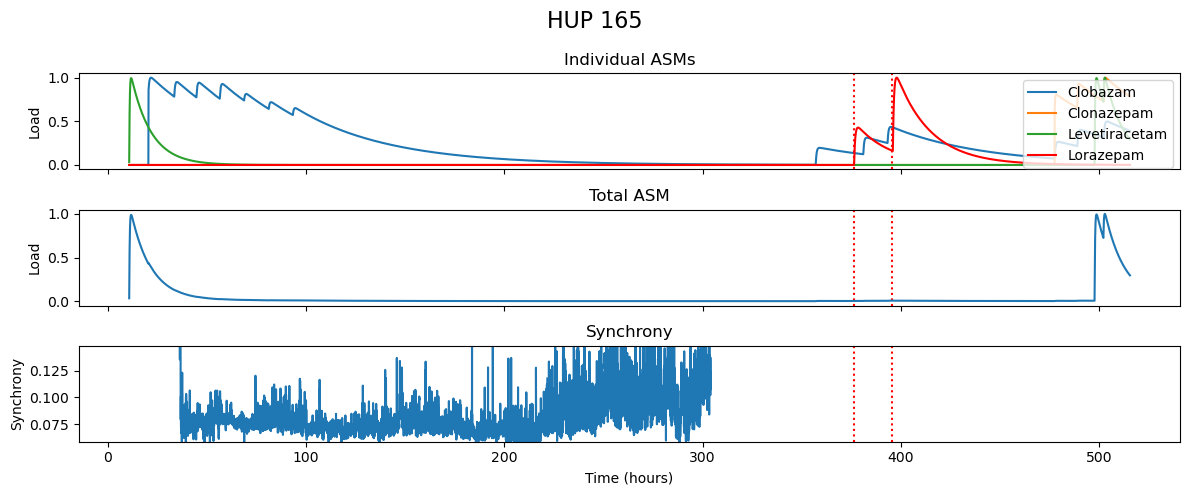

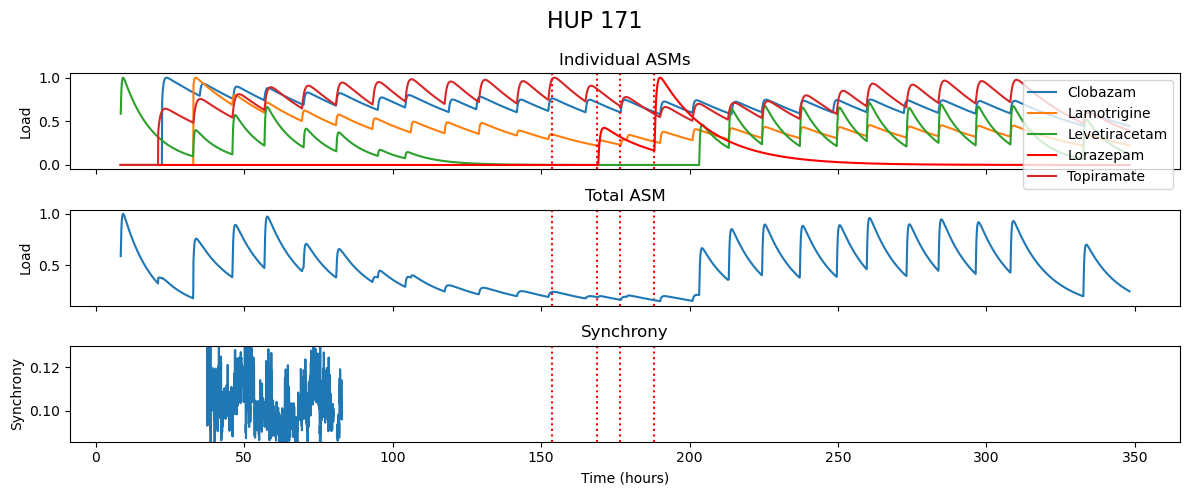

In [4]:
def combined_plot(hourly_patient_features_df, hup_id):
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 5), sharex=True)

    # Convert minutes to hours
    hourly_patient_features_df["emu_hour"] = (
        hourly_patient_features_df["emu_minute"] / 60.0
    )

    # Plotting Individual ASMs
    med_cols = [
        col
        for col in hourly_patient_features_df.columns
        if col.startswith("med_") and not hourly_patient_features_df[col].eq(0).all()
    ]
    med_cols_no_raw = [col.split("_raw")[0] for col in med_cols]

    for i, col in enumerate(med_cols):
        if col not in ["med_sum_no_lorazepam_raw", "med_sum_no_lorazepam_ddd"]:
            label = med_cols_no_raw[i].replace("med_", "")
            normalized_data = (
                hourly_patient_features_df[col] / hourly_patient_features_df[col].max()
            )
            color = "red" if "lorazepam" in label else None
            # Capitalize the first letter of the label
            label = label[0].upper() + label[1:]
            ax0.plot(
                hourly_patient_features_df["emu_hour"],  # Use emu_hour here
                normalized_data,
                label=label,
                color=color,
            )

    seizure_hours = hourly_patient_features_df[
        hourly_patient_features_df["had_seizure"] >= 1
    ][
        "emu_hour"
    ].values  # Use emu_hour here
    for idx in seizure_hours:
        ax0.axvline(x=idx, color="red", linestyle="dotted")
        ax1.axvline(x=idx, color="red", linestyle="dotted")
        ax2.axvline(x=idx, color="red", linestyle="dotted")

    ax0.set_ylabel("Load")
    ax0.set_title("Individual ASMs")
    ax0.legend(loc="upper right")

    # Plotting Total ASM
    ax1.plot(
        hourly_patient_features_df["emu_hour"],  # Use emu_hour here
        hourly_patient_features_df["med_sum_no_lorazepam_raw"],
    )
    ax1.set_ylabel("Load")
    ax1.set_title("Total ASM")

    # Plotting synchrony (broadband Band)
    ax2.plot(
        hourly_patient_features_df["emu_hour"],  # Use emu_hour here
        hourly_patient_features_df["synchrony_broadband"],
    )
    ax2.set_ylabel("Synchrony")
    # Set y axis limits according to the distribution of synchrony values
    ax2.set_ylim(
        np.nanpercentile(hourly_patient_features_df["synchrony_broadband"], 1),
        np.nanpercentile(hourly_patient_features_df["synchrony_broadband"], 99),
    )
    ax2.set_title("Synchrony")
    ax2.set_xlabel("Time (hours)")  # Changed from minutes to hours

    # Subtitle
    fig.suptitle(f"HUP {hup_id}", fontsize=16)
    plt.tight_layout()
    plt.show()


# Loop to call combined_plot
for patient_hup_id in completed_hup_ids:
    hourly_patient_features_df = pd.read_csv(
        os.path.join(NEW_TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
    )
    combined_plot(hourly_patient_features_df, patient_hup_id)